# Creating the Bathymetry
In this notebook, we will explore how to create the grid of a model. This will be demonstrated for Mike's example model in the California current. You are encouraged to follow along with this notebook to generate the model grid in the domain for your project.

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import xarray as xr
from osgeo import gdal, osr
from scipy.interpolate import griddata, RegularGridInterpolator

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [2]:
#mikes way of importing TIFF file 
file_path = '/Users/rilee/MS 274/Lectures/Week 8/Elkhorn_Bathy.tif'
ds = gdal.Open(file_path)
A = np.array(ds.GetRasterBand(1).ReadAsArray())
rows = np.shape(A) [0]
cols = np.shape(A) [1]
transform = ds.GetGeoTransform()
extents = [transform[0], transform[0]+transform[1]*cols,transform[3]+ transform[5]*rows]

C:\Users\rilee\miniconda3\envs\ms274\Lib\site-packages\osgeo\gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [3]:
# Import my model grid 
x_min, x_max = -121.795, -121.739
y_min, y_max =  36.80,    36.861
rn_rows, rn_cols = 240, 360

rdelX = 0.00015556
rdelY = 0.00025417
rxc = np.arange(x_min + rdelX/2, x_max + rdelX/2, rdelX)  # lon centers
ryc = np.arange(y_min + rdelY/2, y_max + rdelY/2, rdelY)  # lat centers
rXC, rYC = np.meshgrid(rxc, ryc)

# Define bounding box for bathymetry model grid
min_lon, max_lon = np.nanmin(rXC), np.nanmax(rXC)
min_lat, max_lat = np.nanmin(rYC), np.nanmax(rYC)

# Read and warp source raster to EPSG:4326 at modest resolution
src = gdal.Open(file_path)
band = ds.GetRasterBand(1)
src_nodata = band.GetNoDataValue()

# Decide a safe on-screen pixel budget (tweak if needed)
rows, cols = ds.RasterYSize, ds.RasterXSize
target_px = 8_000_000  # ~8 MP is plenty for plotting
stride = int(np.ceil(((rows * cols) / target_px) ** 0.5))
w = max(1, cols // stride)
h = max(1, rows // stride)

warp_kwargs = dict(
    format="VRT",              # keep in-memory (no file)
    dstSRS="EPSG:4326",
    resampleAlg=gdal.GRA_Average,
    outputBounds=(min_lon, min_lat, max_lon, max_lat), 
    width=w, height=h)

vrt = gdal.Warp("", src, **warp_kwargs)

Aw = vrt.ReadAsArray().astype(np.float32, copy=False)
dst_nodata = vrt.GetRasterBand(1).GetNoDataValue()
gtw = vrt.GetGeoTransform()

# lon/lat centers for the warped grid
lonc = gtw[0] + (np.arange(vrt.RasterXSize) + 0.5) * gtw[1]
latc = gtw[3] + (np.arange(vrt.RasterYSize) + 0.5) * gtw[5]

# Make 2D coordinate arrays
lon2d, lat2d = np.meshgrid(lonc, latc)

# Flatten for interpolation
points = np.column_stack([lon2d.ravel(), lat2d.ravel()])
values = Aw.ravel()

RModel_bathy = griddata(
    points=points,
    values=values,
    xi=(rXC, rYC),
    method="nearest"
)

print('Double check shape:', np.shape(rxc),np.shape(ryc))

Double check shape: (360,) (240,)


### Double check that the bathymetry file has been read in correctly 
Plot the bathymetry file to ensure that the model grid is included, and the elevation has been read in correctly.

C:\Users\rilee\miniconda3\envs\ms274\Lib\site-packages\matplotlib\colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


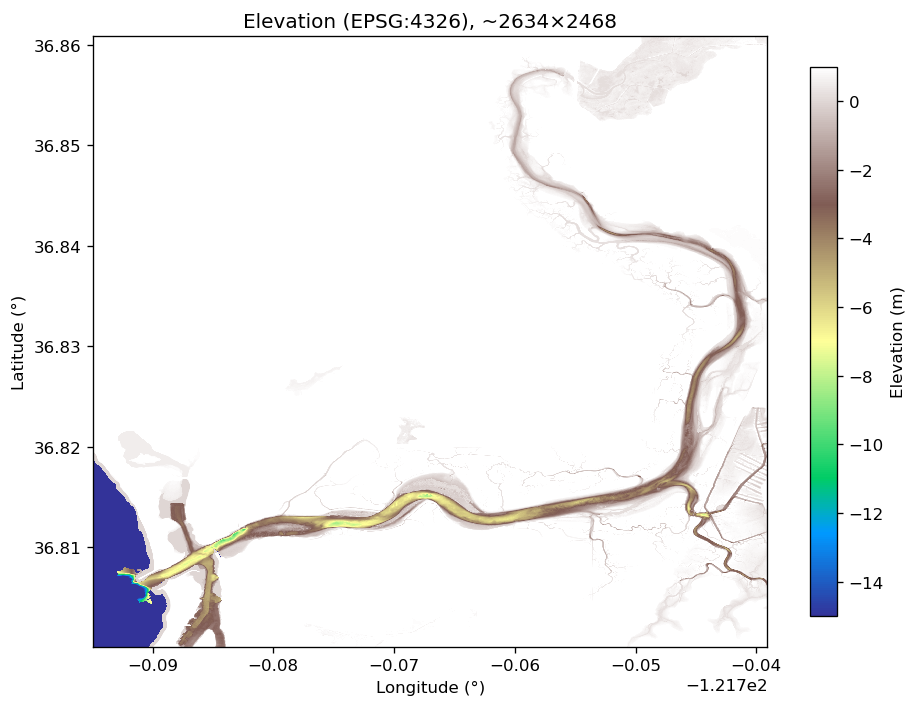

In [4]:

# Plot with pcolormesh (memory-friendly)
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
cmap = plt.get_cmap("terrain").copy()
cmap.set_bad(alpha=0.0)

pcm = ax.pcolormesh(lonc, latc, Aw, vmin=-15, vmax=1,shading="auto", cmap=cmap)
cbar = fig.colorbar(pcm, ax=ax, shrink=0.9)
cbar.set_label("Elevation (m)")

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title(f"Elevation (EPSG:4326), ~{vrt.RasterXSize}×{vrt.RasterYSize}")
plt.tight_layout()
plt.show()


### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

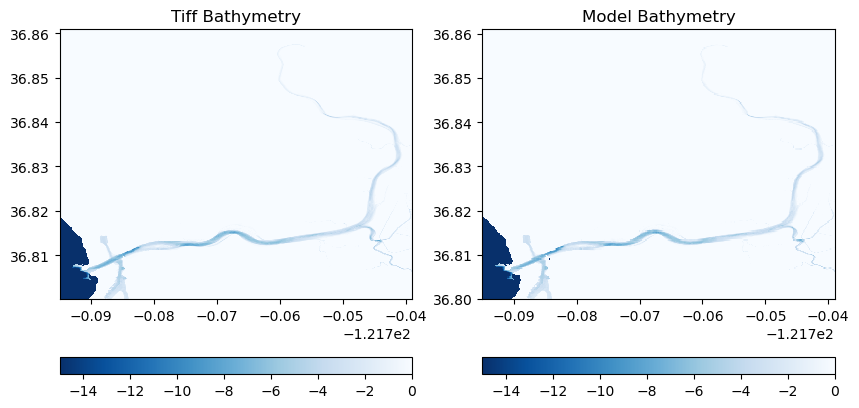

In [5]:
# Plot with pcolormesh (memory-friendly)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
C = plt.pcolormesh(lonc, latc, Aw, vmin=-15, vmax=0,shading="auto", cmap='Blues_r')
plt.colorbar(C,orientation = 'horizontal')
plt.title('Tiff Bathymetry')


plt.subplot(1,2,2)
C = plt.pcolormesh(rXC, rYC, RModel_bathy, vmin=-15, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Double check for problem areas and output bathymetry.bin file

The bathymetry model looks good so we can save our new bin file

In [6]:
output_file = 'slough_bathymetry.bin'
RModel_bathy.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'slough_bathymetry.bin,
 &
```